In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from darts.models import AutoARIMA


In [20]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour."""

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


In [21]:
# url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
# pdf = pd.read_csv(url,index_col=None)


pdf = pd.read_csv("../data/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])
pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings

pdf["total"] = pdf["Value_NE5"].values + pdf["Value_NE7"].values
pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])


split = int(len(pdf)*0.9)
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_12572\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


,total
Timestamp,
2015-01-01,6.709087e+06
2015-01-02,7.073348e+06
2015-01-03,7.149544e+06
2015-01-04,6.724467e+06
2015-01-05,8.585045e+06
...,...
2023-06-15,7.271072e+06
2023-06-16,7.173852e+06
2023-06-17,6.233946e+06


In [22]:
from darts.timeseries import TimeSeries

ytrain = TimeSeries.from_dataframe(pdf_train)
ytest  = TimeSeries.from_dataframe(pdf_test)


In [38]:
forecaster = AutoARIMA(m=7)) 

forecaster.fit(ytrain)  

AutoARIMA(add_encoders=None, m=7, d=1)

In [39]:
y_pred = forecaster.predict(n=300)
y_pred = y_pred.pd_series()

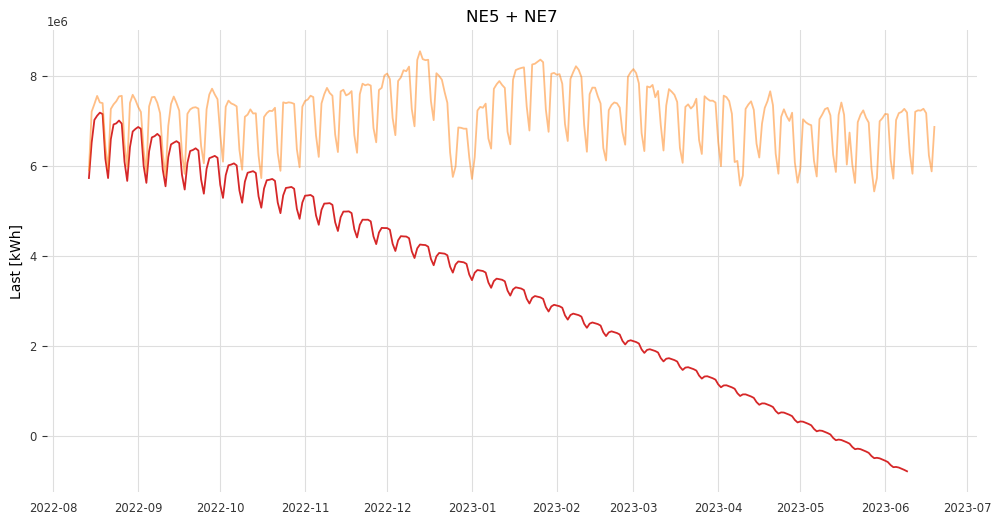

In [40]:


plt.figure(figsize=(12, 6))

plt.plot(y_pred, color="tab:red", label="forcast")
#plt.plot(pdf_train, color="tab:blue", label="train")
plt.plot(pdf_test, color="tab:orange", label="truth", alpha=0.5)
plt.title("NE5 + NE7")
plt.ylabel("Last [kWh]")
#plt.ylim(4e6, 9e6)
plt.show()
